In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


2025-07-17 14:41:59.513588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752763319.877937      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752763319.975360      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Num GPUs Available: 2


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.2 MB/s eta 0:00:00:00:0100:01


In [3]:

import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from tensorflow.keras.optimizers import Adam
import rasterio
from rasterio.enums import Resampling
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [4]:
data_path = "/kaggle/input/satalite-dataset/data"
images_path = os.path.join(data_path, "images")
labels_path = os.path.join(data_path, "labels")
image_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')

image_files = [f for f in os.listdir(images_path) if f.lower().endswith(image_extensions)]

label_files = [
    f for f in os.listdir(labels_path)
    if f.lower().endswith(image_extensions) and '_' not in os.path.splitext(f)[0]
]


print(f"Number of images: {len(image_files)}")
print(f"Number of labels: {len(label_files)}")


Number of images: 306
Number of labels: 306


In [7]:
def display_image_and_mask(img_path, mask_path):
    # Check file extension to decide how to open
    if img_path.lower().endswith(('.tif', '.tiff')):
        try:
            with rasterio.open(img_path) as src:
                # Use standard RGB bands: R=4, G=3, B=2 (1-based indexing)
                rgb_bands = [4, 3, 2]
                valid_bands = [b for b in rgb_bands if b <= src.count]

                if len(valid_bands) < 3:
                    print(f"❌ Image {img_path} does not contain enough RGB bands.")
                    return

                img = src.read(valid_bands)  # Read bands R, G, B
                img = np.transpose(img, (1, 2, 0))  # Convert to (H, W, C)

                # Normalize each channel separately to 0-255 for better visualization
                img = (img - img.min()) / (img.max() - img.min()) * 255
                img = img.astype(np.uint8)

        except Exception as e:
            print(f"❌ Error reading image file {img_path} with rasterio: {e}")
            return
    else:
        try:
            img = Image.open(img_path)
        except Exception as e:
            print(f"❌ Error reading image file {img_path} with PIL: {e}")
            return

    try:
        mask = Image.open(mask_path)
    except Exception as e:
        print(f"❌ Error reading mask file {mask_path} with PIL: {e}")
        return

    # Plot the image and the mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[0].set_title('Image (RGB Bands 4-3-2)')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


✅ Displaying first 5 image-mask pairs from 306 available...


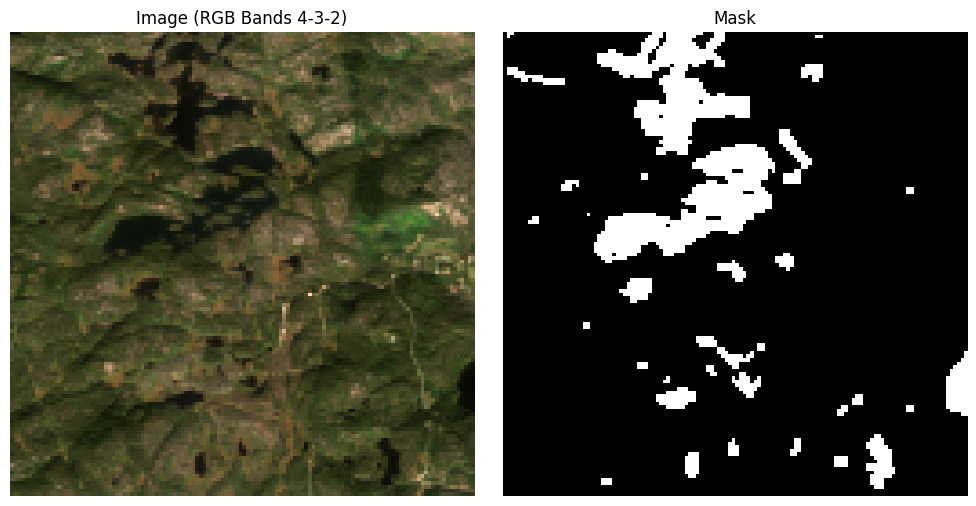

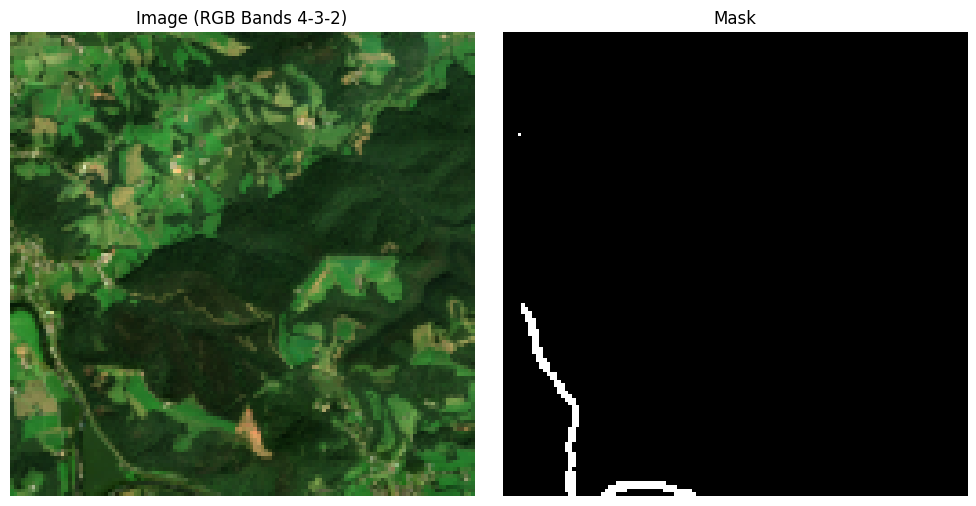

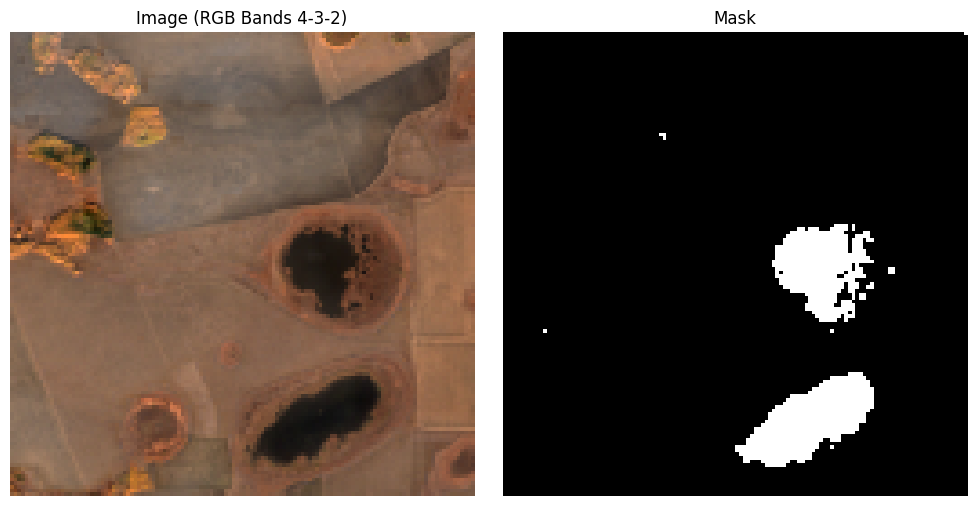

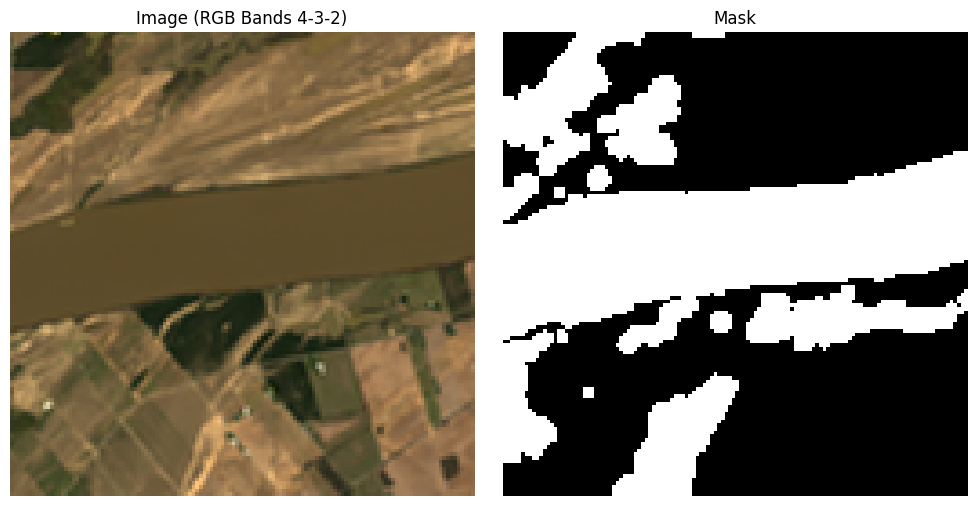

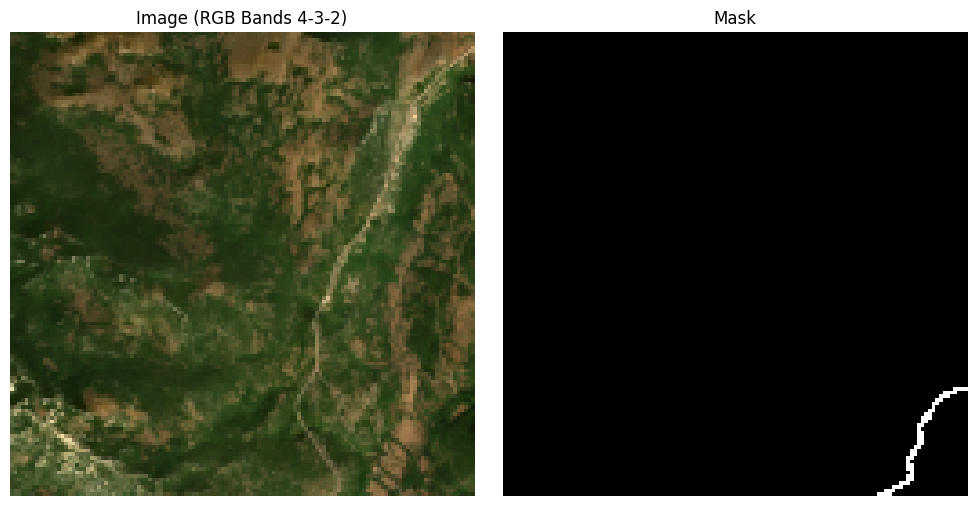

In [8]:
data_path = "/kaggle/input/satalite-dataset/data"
train_img_dir = os.path.join(data_path, "images")
train_mask_dir = os.path.join(data_path, "labels")

# Filter valid image/mask files
image_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')

train_img_files = sorted([f for f in os.listdir(train_img_dir) if f.lower().endswith(image_extensions)])
train_mask_files = sorted([f for f in os.listdir(train_mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg')) and '_' not in f]) # Filter masks for common image types


# Confirm alignment - assuming image and mask filenames are the same except for extension
# This is a simplified check, a more robust approach would match base filenames
img_basenames = [os.path.splitext(f)[0] for f in train_img_files]
mask_basenames = [os.path.splitext(f)[0] for f in train_mask_files]

# Find common basenames
common_basenames = sorted(list(set(img_basenames) & set(mask_basenames)))

if len(common_basenames) == 0:
    print("❌ Error: No matching image and mask files found.")
else:
    print(f"✅ Displaying first 5 image-mask pairs from {len(common_basenames)} available...")
    for basename in common_basenames[:5]:
        # Find the full path for the image and mask using the basename
        img_file = next((f for f in train_img_files if os.path.splitext(f)[0] == basename), None)
        mask_file = next((f for f in train_mask_files if os.path.splitext(f)[0] == basename), None)

        if img_file and mask_file:
            img_path = os.path.join(train_img_dir, img_file)
            mask_path = os.path.join(train_mask_dir, mask_file)
            display_image_and_mask(img_path, mask_path)
        else:
            print(f"Warning: Could not find matching image or mask for basename {basename}")

In [11]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

def extract_number(fname):
    return int(os.path.splitext(fname)[0])

image_files = [f for f in os.listdir(images_path) if f.endswith('.tif')]
label_files = [f for f in os.listdir(labels_path) if f.endswith('.png') and '_' not in f]

image_dict = {extract_number(f): os.path.join(images_path, f) for f in image_files}
label_dict = {extract_number(f): os.path.join(labels_path, f) for f in label_files}

common_keys = sorted(set(image_dict.keys()) & set(label_dict.keys()))

print(f"Found {len(common_keys)} matching image-label pairs.")

X, Y = [], []

for k in common_keys:
    img_path = image_dict[k]
    label_path = label_dict[k]

    try:
        with rasterio.open(img_path) as src:
            img = src.read(out_shape=(src.count, IMG_HEIGHT, IMG_WIDTH), resampling=rasterio.enums.Resampling.nearest)
            img = img.astype(np.float32)
            for b in range(img.shape[0]):
                band = img[b]
                # img[b] = (band - band.min()) / (band.max() - band.min() + 1e-8) # normalize
            img = np.transpose(img, (1, 2, 0))


        with rasterio.open(label_path) as lbl_src:
            label = lbl_src.read(1)
            label = cv2.resize(label, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
            label = (label > 0).astype(np.uint8)

        X.append(img)
        Y.append(label)

    except Exception as e:
        print(f"Error loading {img_path} or {label_path}: {e}")


X = np.array(X)
Y = np.expand_dims(np.array(Y), axis=-1)

print("X shape:", X.shape)
print("Y shape:", Y.shape)


Found 306 matching image-label pairs.
X shape: (306, 128, 128, 12)
Y shape: (306, 128, 128, 1)


In [12]:
import numpy as np

has_water = [(y > 0).any() for y in Y]

num_with_water = sum(has_water)
num_without_water = len(Y) - num_with_water

print(f"✅ Images with water:     {num_with_water}")
print(f"❌ Images without water:  {num_without_water}")


✅ Images with water:     261
❌ Images without water:  45


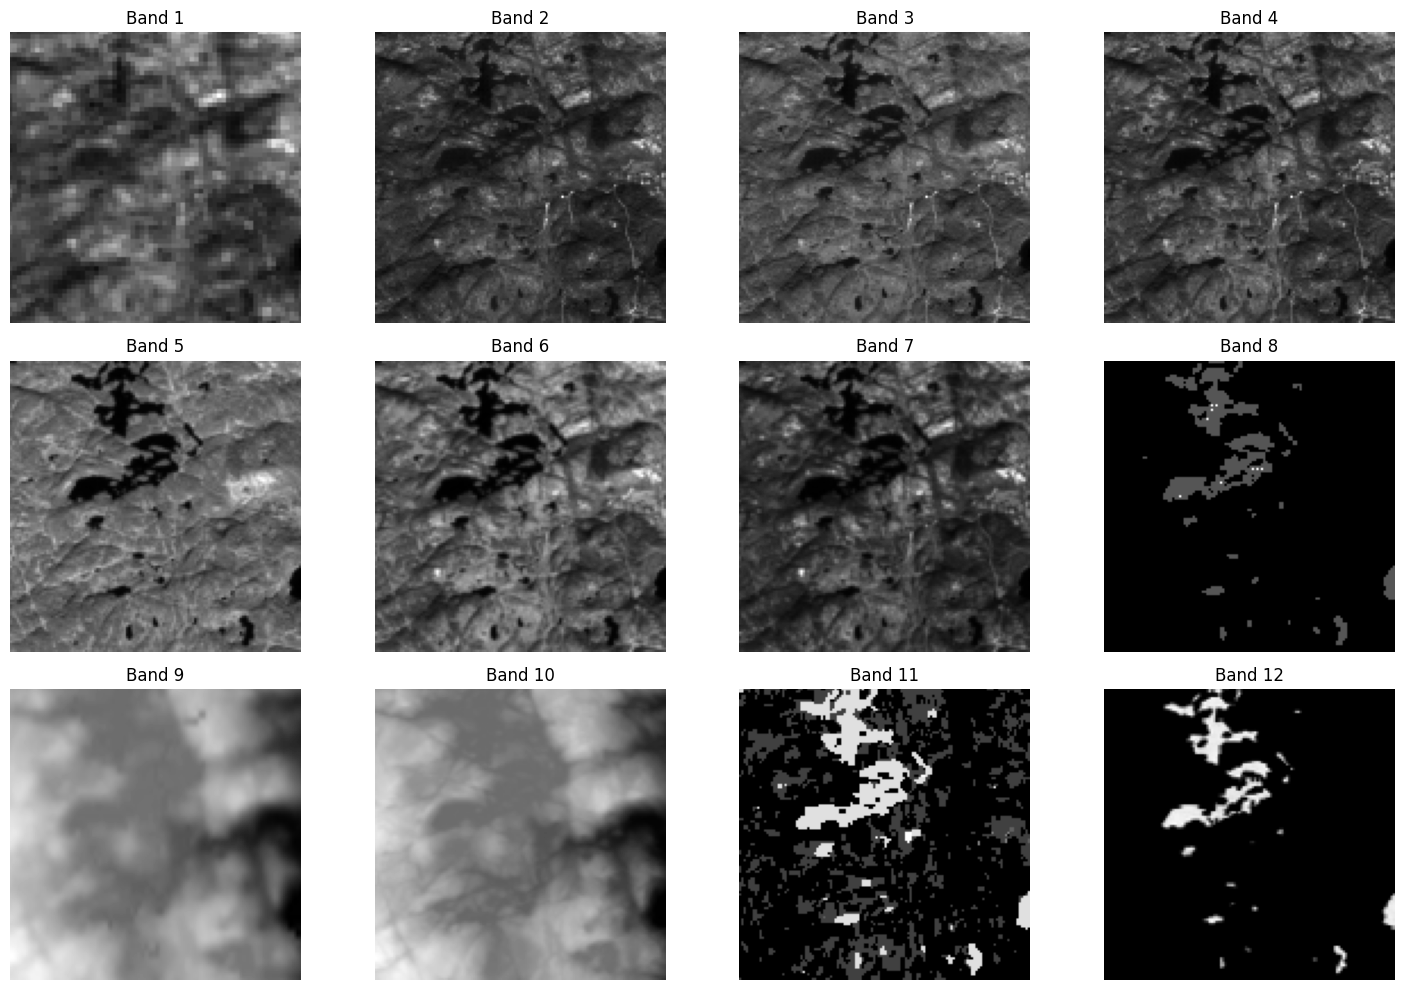

In [15]:

first_image = X[0]
num_bands = first_image.shape[-1]

plt.figure(figsize=(15, 10))

for i in range(num_bands):
    plt.subplot(3, 4, i + 1)
    plt.imshow(first_image[:, :, i], cmap='gray')
    plt.title(f"Band {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
print("Before normalization:")
for i in range(num_bands):
    band = X[:, :, :, i]
    print(f"Band {i+1}: min={band.min():.3f}, max={band.max():.3f}, mean={band.mean():.3f}")

band_mins = np.min(X, axis=(0, 1, 2))
band_maxs = np.max(X, axis=(0, 1, 2))
X_normalized = (X - band_mins) / (band_maxs - band_mins + 1e-8)

print("\nAfter normalization:")
for i in range(num_bands):
    band = X_normalized[:, :, :, i]
    print(f"Band {i+1}: min={band.min():.3f}, max={band.max():.3f}, mean={band.mean():.3f}")
# 8 - 10 - 12
# search on water index

Before normalization:
Band 1: min=-1393.000, max=6568.000, mean=396.468
Band 2: min=-1169.000, max=9659.000, mean=494.621
Band 3: min=-722.000, max=11368.000, mean=822.320
Band 4: min=-684.000, max=12041.000, mean=973.675
Band 5: min=-412.000, max=15841.000, mean=2090.111
Band 6: min=-335.000, max=15252.000, mean=1964.051
Band 7: min=-258.000, max=14647.000, mean=1351.274
Band 8: min=64.000, max=255.000, mean=102.740
Band 9: min=-9999.000, max=4245.000, mean=141.804
Band 10: min=8.000, max=4287.000, mean=300.741
Band 11: min=10.000, max=100.000, mean=35.103
Band 12: min=0.000, max=111.000, mean=9.753

After normalization:
Band 1: min=0.000, max=1.000, mean=0.225
Band 2: min=0.000, max=1.000, mean=0.154
Band 3: min=0.000, max=1.000, mean=0.128
Band 4: min=0.000, max=1.000, mean=0.130
Band 5: min=0.000, max=1.000, mean=0.154
Band 6: min=0.000, max=1.000, mean=0.147
Band 7: min=0.000, max=1.000, mean=0.108
Band 8: min=0.000, max=1.000, mean=0.203
Band 9: min=0.000, max=1.000, mean=0.712
B

In [18]:
# # Band indices (0-based): Blue=1, Green=2, Red=3, NIR=7, Water Vapor=8, SWIR-1=10, SWIR-2=11

# selected_band_indices = [1, 2, 3, 7, 8, 10, 11]
selected_band_indices = [2 , 3 , 4 ,5 ,6 , 7, 10 , 11]
# 
# Recommended bands: Blue, Green, Red, NIR, SWIR1, SWIR2, Water Occurrence Probability
# selected_band_indices = [1, 2, 3, 4, 5, 6, 11]

X_selected = X[:, :, :, selected_band_indices]

print("Original X shape:", X.shape)
print("Filtered X shape:", X_selected.shape)

Original X shape: (306, 128, 128, 12)
Filtered X shape: (306, 128, 128, 8)


In [19]:

X_train, X_val, Y_train, Y_val = train_test_split(
    X_selected, Y, test_size=0.2, random_state=SEED, stratify=None
)

# Print shapes
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

X_train shape: (244, 128, 128, 8)
Y_train shape: (244, 128, 128, 1)
X_val shape: (62, 128, 128, 8)
Y_val shape: (62, 128, 128, 1)


In [20]:
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42


def augment(image, mask):
    # Horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random 90-degree rotation
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    return image, mask


def process_sample(image, mask, training):
    if training:
        image, mask = augment(image, mask)
    return image, mask


def prepare_dataset(X, Y, training=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))

    if training:
        dataset = dataset.shuffle(buffer_size=len(X), seed=SEED, reshuffle_each_iteration=True)

    dataset = dataset.map(lambda img, mask: process_sample(img, mask, training),
                          num_parallel_calls=AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

In [21]:
train_dataset = prepare_dataset(X_train, Y_train, training=True)
val_dataset   = prepare_dataset(X_val, Y_val, training=False)

I0000 00:00:1752763849.856217      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752763849.856911      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [22]:
INPUT_SHAPE = (128, 128, len(selected_band_indices))


def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def unet_base(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    return models.Model(inputs, outputs)



def residual_block(x, filters, dilation=1):
    skip = x

    # Project skip connection to match x's shape if necessary
    if skip.shape[-1] != filters:
        skip = layers.Conv2D(filters, 1, padding='same')(skip)

    x = layers.Conv2D(filters, 3, padding='same', dilation_rate=dilation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding='same', dilation_rate=dilation)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, skip])  # Now skip has same shape as x
    x = layers.ReLU()(x)

    return x


def resunet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    x1 = residual_block(inputs, 64)
    p1 = layers.MaxPooling2D()(x1)

    x2 = residual_block(p1, 128)
    p2 = layers.MaxPooling2D()(x2)

    x3 = residual_block(p2, 256)
    p3 = layers.MaxPooling2D()(x3)

    x4 = residual_block(p3, 512)
    p4 = layers.MaxPooling2D()(x4)

    x5 = residual_block(p4, 1024)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(x5)
    u6 = layers.concatenate([u6, x4])
    x6 = residual_block(u6, 512)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x6)
    u7 = layers.concatenate([u7, x3])
    x7 = residual_block(u7, 256)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x7)
    u8 = layers.concatenate([u8, x2])
    x8 = residual_block(u8, 128)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(x8)
    u9 = layers.concatenate([u9, x1])
    x9 = residual_block(u9, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x9)

    return models.Model(inputs, outputs)


def dilated_resunet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder with dilated convolutions
    x1 = residual_block(inputs, 64, dilation=1)
    p1 = layers.MaxPooling2D()(x1)

    x2 = residual_block(p1, 128, dilation=2)
    p2 = layers.MaxPooling2D()(x2)

    x3 = residual_block(p2, 256, dilation=4)
    p3 = layers.MaxPooling2D()(x3)

    x4 = residual_block(p3, 512, dilation=8)

    # Decoder
    u3 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x4)
    u3 = layers.concatenate([u3, x3])
    d3 = residual_block(u3, 256)

    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(d3)
    u2 = layers.concatenate([u2, x2])
    d2 = residual_block(u2, 128)

    u1 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(d2)
    u1 = layers.concatenate([u1, x1])
    d1 = residual_block(u1, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d1)

    return models.Model(inputs, outputs)

def attention_gate(x, g, filters):
    theta_x = layers.Conv2D(filters, 1, padding='same')(x)
    phi_g = layers.Conv2D(filters, 1, padding='same')(g)
    add = layers.Add()([theta_x, phi_g])
    act = layers.ReLU()(add)
    psi = layers.Conv2D(1, 1)(act)
    psi = layers.Activation('sigmoid')(psi)
    return layers.Multiply()([x, psi])


def aer_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    x1 = conv_block(inputs, 64); p1 = layers.MaxPooling2D()(x1)
    x2 = conv_block(p1, 128); p2 = layers.MaxPooling2D()(x2)
    x3 = conv_block(p2, 256); p3 = layers.MaxPooling2D()(x3)
    x4 = conv_block(p3, 512); p4 = layers.MaxPooling2D()(x4)
    x5 = conv_block(p4, 1024)

    # Decoder with attention
    u4 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(x5)
    att4 = attention_gate(x4, u4, 256)
    m4 = layers.Concatenate()([u4, att4])
    x6 = conv_block(m4, 512)

    u3 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x6)
    att3 = attention_gate(x3, u3, 128)
    m3 = layers.Concatenate()([u3, att3])
    x7 = conv_block(m3, 256)

    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x7)
    att2 = attention_gate(x2, u2, 64)
    m2 = layers.Concatenate()([u2, att2])
    x8 = conv_block(m2, 128)

    u1 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(x8)
    att1 = attention_gate(x1, u1, 32)
    m1 = layers.Concatenate()([u1, att1])
    x9 = conv_block(m1, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x9)
    return models.Model(inputs, outputs)


In [23]:
model_variants = {
    "UNet_Base": unet_base,
    "Resunet": resunet,
    "Dilated_resunet": dilated_resunet,
    "Aer_unet": aer_unet
}


In [24]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


In [25]:
# learning_rates = [1e-4, 5e-4, 1e-3]
learning_rates = [1e-4, 5e-5, 1e-5]
epochs = 30

In [26]:
def bce_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(y_true, y_pred)


# binary_crosentropy


In [27]:
def weighted_bce(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)


    total_pixels = np.prod(Y.shape[:-1])
    water_pixels = np.sum(Y)
    background_pixels = total_pixels - water_pixels

    weight_for_0 = total_pixels / (2 * background_pixels)
    weight_for_1 = total_pixels / (2 * water_pixels)


    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    weight_map = weight_for_0 * (1 - y_true) + weight_for_1 * y_true
    return tf.reduce_mean(bce * weight_map)


In [28]:
# from tensorflow.keras.losses import binary_crossentropy

def combo_loss(y_true, y_pred):
    return weighted_bce(y_true, y_pred) + bce_loss(y_true, y_pred)



In [29]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-6)


In [30]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    y_true = tf.cast(y_true, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)

    return 2 * (precision * recall) / (precision + recall + 1e-8)


In [31]:
import numpy as np
print("Max values in first 5 masks:", [Y[i].max() for i in range(5)])


Max values in first 5 masks: [1, 1, 1, 1, 1]


In [32]:
results = []

## UNet_Base model

In [33]:
model_1_unet_base = unet_base(INPUT_SHAPE)
model_1_unet_base.compile(
    optimizer=Adam(learning_rate=learning_rates[0]),
    loss=combo_loss,
    metrics=['accuracy',iou_metric,f1_score]
)
history_unet_base_1 = model_1_unet_base.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs, # 27
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
            "Model": "UNet_Base",
            "LR": learning_rates[0],
            "Val_Accuracy": history_unet_base_1.history['val_accuracy'][-1],
            "iou_metric" : history_unet_base_1.history['val_iou_metric'][-1],
            "Val_F1": history_unet_base_1.history['val_f1_score'][-1]
}

results.append(final_metrics)
print(f"UNet_Base @ {learning_rates[0]:.0e} → Acc: {final_metrics['Val_Accuracy']:.4f} | F1: {final_metrics['Val_F1']:.4f}")



Epoch 1/30


I0000 00:00:1752763888.924158     110 service.cc:148] XLA service 0x79edec001e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752763888.927448     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752763888.927477     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752763890.145738     110 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752763917.264659     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
E0000 00:00:1752763926.536683     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752763926.752509     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, ple

16/16 - 75s - 5s/step - accuracy: 0.8156 - f1_score: 0.6373 - iou_metric: 0.4801 - loss: 11.7237 - val_accuracy: 0.8738 - val_f1_score: 0.7730 - val_iou_metric: 0.6333 - val_loss: 4.8100
Epoch 2/30
16/16 - 4s - 249ms/step - accuracy: 0.8509 - f1_score: 0.6980 - iou_metric: 0.5392 - loss: 5.6914 - val_accuracy: 0.8960 - val_f1_score: 0.7979 - val_iou_metric: 0.6652 - val_loss: 4.7043
Epoch 3/30
16/16 - 4s - 249ms/step - accuracy: 0.8337 - f1_score: 0.6542 - iou_metric: 0.4926 - loss: 4.3111 - val_accuracy: 0.8892 - val_f1_score: 0.7905 - val_iou_metric: 0.6554 - val_loss: 3.5926
Epoch 4/30
16/16 - 4s - 250ms/step - accuracy: 0.8421 - f1_score: 0.6531 - iou_metric: 0.5037 - loss: 3.4985 - val_accuracy: 0.8850 - val_f1_score: 0.7895 - val_iou_metric: 0.6548 - val_loss: 2.7736
Epoch 5/30
16/16 - 4s - 252ms/step - accuracy: 0.8626 - f1_score: 0.7174 - iou_metric: 0.5642 - loss: 3.4705 - val_accuracy: 0.8555 - val_f1_score: 0.7518 - val_iou_metric: 0.6053 - val_loss: 2.3963
Epoch 6/30
16/16 

In [34]:
model_2_unet_base = unet_base(INPUT_SHAPE)
model_2_unet_base.compile(
    optimizer=Adam(learning_rate=learning_rates[1]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_unet_base_2 = model_2_unet_base.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs, # 8
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "UNet_Base",
    "LR": learning_rates[1],
    "Val_Accuracy": history_unet_base_2.history['val_accuracy'][-1],
    "iou_metric": history_unet_base_2.history['val_iou_metric'][-1],
    "f1_score": history_unet_base_2.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"UNet_Base @ {learning_rates[1]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
16/16 - 25s - 2s/step - accuracy: 0.8308 - f1_score: 0.6321 - iou_metric: 0.4824 - loss: 9.7659 - val_accuracy: 0.8617 - val_f1_score: 0.7608 - val_iou_metric: 0.6172 - val_loss: 5.1055
Epoch 2/30
16/16 - 4s - 264ms/step - accuracy: 0.8415 - f1_score: 0.6859 - iou_metric: 0.5297 - loss: 5.6892 - val_accuracy: 0.7583 - val_f1_score: 0.6546 - val_iou_metric: 0.4890 - val_loss: 4.9366
Epoch 3/30
16/16 - 4s - 267ms/step - accuracy: 0.8203 - f1_score: 0.6515 - iou_metric: 0.4896 - loss: 4.4764 - val_accuracy: 0.8755 - val_f1_score: 0.7754 - val_iou_metric: 0.6357 - val_loss: 3.3438
Epoch 4/30
16/16 - 4s - 267ms/step - accuracy: 0.8425 - f1_score: 0.6879 - iou_metric: 0.5317 - loss: 3.7827 - val_accuracy: 0.8445 - val_f1_score: 0.7411 - val_iou_metric: 0.5920 - val_loss: 3.0747
Epoch 5/30
16/16 - 4s - 273ms/step - accuracy: 0.8454 - f1_score: 0.6750 - iou_metric: 0.5230 - loss: 3.4555 - val_accuracy: 0.8568 - val_f1_score: 0.7520 - val_iou_metric: 0.6054 - val_loss: 2.9048
Epoch 6

In [35]:
model_3_unet_base = unet_base(INPUT_SHAPE)
model_3_unet_base.compile(
    optimizer=Adam(learning_rate=learning_rates[2]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_unet_base_3 = model_3_unet_base.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs, # 28
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "UNet_Base",
    "LR": learning_rates[2],
    "Val_Accuracy": history_unet_base_3.history['val_accuracy'][-1],
    "iou_metric": history_unet_base_3.history['val_iou_metric'][-1],
    "f1_score": history_unet_base_3.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"UNet_Base @ {learning_rates[2]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
16/16 - 25s - 2s/step - accuracy: 0.7390 - f1_score: 0.0068 - iou_metric: 0.0034 - loss: 37.7133 - val_accuracy: 0.6403 - val_f1_score: 0.0149 - val_iou_metric: 0.0075 - val_loss: 35.5817
Epoch 2/30
16/16 - 4s - 274ms/step - accuracy: 0.6078 - f1_score: 0.0741 - iou_metric: 0.0394 - loss: 22.2542 - val_accuracy: 0.6360 - val_f1_score: 0.0797 - val_iou_metric: 0.0416 - val_loss: 19.5979
Epoch 3/30
16/16 - 4s - 276ms/step - accuracy: 0.7027 - f1_score: 0.2826 - iou_metric: 0.1734 - loss: 11.8304 - val_accuracy: 0.8172 - val_f1_score: 0.6336 - val_iou_metric: 0.4658 - val_loss: 8.1055
Epoch 4/30
16/16 - 5s - 281ms/step - accuracy: 0.8025 - f1_score: 0.5531 - iou_metric: 0.3877 - loss: 8.0149 - val_accuracy: 0.8082 - val_f1_score: 0.6803 - val_iou_metric: 0.5186 - val_loss: 6.2552
Epoch 5/30
16/16 - 5s - 287ms/step - accuracy: 0.8128 - f1_score: 0.6160 - iou_metric: 0.4501 - loss: 6.8463 - val_accuracy: 0.8234 - val_f1_score: 0.7035 - val_iou_metric: 0.5461 - val_loss: 5.6986
Ep

## Resunet

In [36]:
model_1_Resunet = resunet(INPUT_SHAPE)
model_1_Resunet.compile(
    optimizer=Adam(learning_rate=learning_rates[0]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Resunet_1 = model_1_Resunet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Resunet",
    "LR": learning_rates[0],
    "Val_Accuracy": history_Resunet_1.history['val_accuracy'][-1],
    "iou_metric": history_Resunet_1.history['val_iou_metric'][-1],
    "f1_score": history_Resunet_1.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Resunet @ {learning_rates[0]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
16/16 - 65s - 4s/step - accuracy: 0.7527 - f1_score: 0.0409 - iou_metric: 0.0221 - loss: 101.8059 - val_accuracy: 0.7630 - val_f1_score: 0.3390 - val_iou_metric: 0.2042 - val_loss: 58.7722
Epoch 2/30
16/16 - 5s - 329ms/step - accuracy: 0.8280 - f1_score: 0.6087 - iou_metric: 0.4533 - loss: 36.3779 - val_accuracy: 0.8821 - val_f1_score: 0.7793 - val_iou_metric: 0.6406 - val_loss: 19.2680
Epoch 3/30
16/16 - 5s - 334ms/step - accuracy: 0.8443 - f1_score: 0.6753 - iou_metric: 0.5165 - loss: 19.6310 - val_accuracy: 0.8721 - val_f1_score: 0.7715 - val_iou_metric: 0.6312 - val_loss: 13.3525
Epoch 4/30
16/16 - 5s - 339ms/step - accuracy: 0.8543 - f1_score: 0.6978 - iou_metric: 0.5433 - loss: 13.7622 - val_accuracy: 0.8638 - val_f1_score: 0.7629 - val_iou_metric: 0.6204 - val_loss: 9.8463
Epoch 5/30
16/16 - 5s - 343ms/step - accuracy: 0.8445 - f1_score: 0.6812 - iou_metric: 0.5221 - loss: 9.8180 - val_accuracy: 0.8693 - val_f1_score: 0.7590 - val_iou_metric: 0.6143 - val_loss: 7.7030

In [37]:
model_2_Resunet = resunet(INPUT_SHAPE)
model_2_Resunet.compile(
    optimizer=Adam(learning_rate=learning_rates[1]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Resunet_2 = model_2_Resunet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Resunet",
    "LR": learning_rates[1],
    "Val_Accuracy": history_Resunet_2.history['val_accuracy'][-1],
    "iou_metric": history_Resunet_2.history['val_iou_metric'][-1],
    "f1_score": history_Resunet_2.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Resunet @ {learning_rates[1]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
16/16 - 51s - 3s/step - accuracy: 0.6595 - f1_score: 0.4441 - iou_metric: 0.2888 - loss: 24.1126 - val_accuracy: 0.7582 - val_f1_score: 0.4059 - val_iou_metric: 0.2557 - val_loss: 18.1794
Epoch 2/30
16/16 - 5s - 318ms/step - accuracy: 0.8311 - f1_score: 0.5822 - iou_metric: 0.4173 - loss: 11.9509 - val_accuracy: 0.8194 - val_f1_score: 0.6455 - val_iou_metric: 0.4788 - val_loss: 10.9266
Epoch 3/30
16/16 - 5s - 321ms/step - accuracy: 0.8457 - f1_score: 0.6616 - iou_metric: 0.5071 - loss: 9.6984 - val_accuracy: 0.8625 - val_f1_score: 0.7520 - val_iou_metric: 0.6072 - val_loss: 8.7561
Epoch 4/30
16/16 - 5s - 327ms/step - accuracy: 0.8538 - f1_score: 0.6872 - iou_metric: 0.5315 - loss: 9.0347 - val_accuracy: 0.8571 - val_f1_score: 0.7432 - val_iou_metric: 0.5961 - val_loss: 8.4919
Epoch 5/30
16/16 - 5s - 333ms/step - accuracy: 0.8448 - f1_score: 0.6832 - iou_metric: 0.5238 - loss: 8.5421 - val_accuracy: 0.8470 - val_f1_score: 0.7244 - val_iou_metric: 0.5723 - val_loss: 8.3944
Epo

In [38]:
model_3_Resunet = resunet(INPUT_SHAPE)
model_3_Resunet.compile(
    optimizer=Adam(learning_rate=learning_rates[2]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Resunet_3 = model_3_Resunet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Resunet",
    "LR": learning_rates[2],
    "Val_Accuracy": history_Resunet_3.history['val_accuracy'][-1],
    "iou_metric": history_Resunet_3.history['val_iou_metric'][-1],
    "f1_score": history_Resunet_3.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Resunet @ {learning_rates[2]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
16/16 - 52s - 3s/step - accuracy: 0.7490 - f1_score: 0.0017 - iou_metric: 8.5969e-04 - loss: 69.2217 - val_accuracy: 0.7068 - val_f1_score: 7.2657e-04 - val_iou_metric: 3.6350e-04 - val_loss: 85.8277
Epoch 2/30
16/16 - 5s - 315ms/step - accuracy: 0.7493 - f1_score: 0.0039 - iou_metric: 0.0020 - loss: 63.7325 - val_accuracy: 0.7069 - val_f1_score: 0.0016 - val_iou_metric: 7.8271e-04 - val_loss: 79.3793
Epoch 3/30
16/16 - 5s - 320ms/step - accuracy: 0.7499 - f1_score: 0.0098 - iou_metric: 0.0050 - loss: 58.2122 - val_accuracy: 0.7070 - val_f1_score: 0.0034 - val_iou_metric: 0.0017 - val_loss: 72.6011
Epoch 4/30
16/16 - 5s - 322ms/step - accuracy: 0.7510 - f1_score: 0.0253 - iou_metric: 0.0130 - loss: 52.4033 - val_accuracy: 0.7072 - val_f1_score: 0.0068 - val_iou_metric: 0.0034 - val_loss: 65.3699
Epoch 5/30
16/16 - 5s - 331ms/step - accuracy: 0.7522 - f1_score: 0.0389 - iou_metric: 0.0202 - loss: 46.0054 - val_accuracy: 0.7075 - val_f1_score: 0.0156 - val_iou_metric: 0.0079 -

## Dilated_resunet

In [39]:
model_1_Dilated_resunet = dilated_resunet(INPUT_SHAPE)
model_1_Dilated_resunet.compile(
    optimizer=Adam(learning_rate=learning_rates[0]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Dilated_resunet_1 = model_1_Dilated_resunet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Dilated_resunet",
    "LR": learning_rates[0],
    "Val_Accuracy": history_Dilated_resunet_1.history['val_accuracy'][-1],
    "iou_metric": history_Dilated_resunet_1.history['val_iou_metric'][-1],
    "f1_score": history_Dilated_resunet_1.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Dilated_resunet @ {learning_rates[0]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30


2025-07-17 15:08:28.495073: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[512,1024,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,512,3,3]{3,2,1,0}, f32[1024,512,2,2]{3,2,1,0}), window={size=2x2 pad=1_1x1_1 rhs_reversal=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-07-17 15:08:28.527570: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.03260922s
Trying algorithm eng4{} for conv (f32[512,1024,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,512,3,3]{3,2,1,0}, f32[1024,512,2,2]{3,2,1,0}), window={size=2x2 pad=1_1x1_1 rhs_reversal=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_ba

16/16 - 62s - 4s/step - accuracy: 0.7033 - f1_score: 0.0539 - iou_metric: 0.0296 - loss: 45.6219 - val_accuracy: 0.6531 - val_f1_score: 0.0946 - val_iou_metric: 0.0500 - val_loss: 30.0719
Epoch 2/30
16/16 - 5s - 287ms/step - accuracy: 0.7324 - f1_score: 0.4169 - iou_metric: 0.2832 - loss: 16.9474 - val_accuracy: 0.8547 - val_f1_score: 0.7167 - val_iou_metric: 0.5605 - val_loss: 9.3757
Epoch 3/30
16/16 - 5s - 292ms/step - accuracy: 0.8166 - f1_score: 0.6311 - iou_metric: 0.4698 - loss: 10.0297 - val_accuracy: 0.8885 - val_f1_score: 0.7791 - val_iou_metric: 0.6398 - val_loss: 8.9484
Epoch 4/30
16/16 - 5s - 299ms/step - accuracy: 0.8454 - f1_score: 0.6780 - iou_metric: 0.5161 - loss: 8.8589 - val_accuracy: 0.8837 - val_f1_score: 0.7745 - val_iou_metric: 0.6336 - val_loss: 7.0458
Epoch 5/30
16/16 - 5s - 302ms/step - accuracy: 0.8456 - f1_score: 0.6642 - iou_metric: 0.5055 - loss: 6.8314 - val_accuracy: 0.8276 - val_f1_score: 0.7104 - val_iou_metric: 0.5533 - val_loss: 5.4599
Epoch 6/30
16/

In [40]:
model_2_Dilated_resunet = dilated_resunet(INPUT_SHAPE)
model_2_Dilated_resunet.compile(
    optimizer=Adam(learning_rate=learning_rates[1]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Dilated_resunet_2 = model_2_Dilated_resunet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Dilated_resunet",
    "LR": learning_rates[1],
    "Val_Accuracy": history_Dilated_resunet_2.history['val_accuracy'][-1],
    "iou_metric": history_Dilated_resunet_2.history['val_iou_metric'][-1],
    "f1_score": history_Dilated_resunet_2.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Dilated_resunet @ {learning_rates[1]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
16/16 - 43s - 3s/step - accuracy: 0.4300 - f1_score: 0.3532 - iou_metric: 0.2242 - loss: 49.9528 - val_accuracy: 0.6960 - val_f1_score: 0.1888 - val_iou_metric: 0.1043 - val_loss: 24.1426
Epoch 2/30
16/16 - 4s - 272ms/step - accuracy: 0.8066 - f1_score: 0.4343 - iou_metric: 0.2836 - loss: 16.3970 - val_accuracy: 0.7837 - val_f1_score: 0.4535 - val_iou_metric: 0.2964 - val_loss: 17.1332
Epoch 3/30
16/16 - 4s - 277ms/step - accuracy: 0.8675 - f1_score: 0.6813 - iou_metric: 0.5254 - loss: 11.0899 - val_accuracy: 0.8723 - val_f1_score: 0.7633 - val_iou_metric: 0.6212 - val_loss: 8.4154
Epoch 4/30
16/16 - 5s - 282ms/step - accuracy: 0.8437 - f1_score: 0.6691 - iou_metric: 0.5188 - loss: 8.8455 - val_accuracy: 0.8709 - val_f1_score: 0.7593 - val_iou_metric: 0.6161 - val_loss: 7.0854
Epoch 5/30
16/16 - 5s - 284ms/step - accuracy: 0.8554 - f1_score: 0.6692 - iou_metric: 0.5182 - loss: 7.2101 - val_accuracy: 0.8403 - val_f1_score: 0.6944 - val_iou_metric: 0.5354 - val_loss: 6.9765
Ep

In [41]:
model_3_Dilated_resunet = dilated_resunet(INPUT_SHAPE)
model_3_Dilated_resunet.compile(
    optimizer=Adam(learning_rate=learning_rates[2]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Dilated_resunet_3 = model_3_Dilated_resunet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Dilated_resunet",
    "LR": learning_rates[2],
    "Val_Accuracy": history_Dilated_resunet_3.history['val_accuracy'][-1],
    "iou_metric": history_Dilated_resunet_3.history['val_iou_metric'][-1],
    "f1_score": history_Dilated_resunet_3.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Dilated_resunet @ {learning_rates[2]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
16/16 - 42s - 3s/step - accuracy: 0.2516 - f1_score: 0.3930 - iou_metric: 0.2478 - loss: 176.8017 - val_accuracy: 0.2933 - val_f1_score: 0.4450 - val_iou_metric: 0.2896 - val_loss: 159.1214
Epoch 2/30
16/16 - 4s - 276ms/step - accuracy: 0.2518 - f1_score: 0.4032 - iou_metric: 0.2577 - loss: 151.8055 - val_accuracy: 0.2933 - val_f1_score: 0.4448 - val_iou_metric: 0.2895 - val_loss: 134.7105
Epoch 3/30
16/16 - 5s - 282ms/step - accuracy: 0.2529 - f1_score: 0.3937 - iou_metric: 0.2479 - loss: 127.3424 - val_accuracy: 0.2976 - val_f1_score: 0.4454 - val_iou_metric: 0.2899 - val_loss: 110.4003
Epoch 4/30
16/16 - 5s - 285ms/step - accuracy: 0.2604 - f1_score: 0.3875 - iou_metric: 0.2445 - loss: 102.7934 - val_accuracy: 0.3129 - val_f1_score: 0.4472 - val_iou_metric: 0.2912 - val_loss: 85.7595
Epoch 5/30
16/16 - 5s - 292ms/step - accuracy: 0.2845 - f1_score: 0.4056 - iou_metric: 0.2577 - loss: 78.1836 - val_accuracy: 0.3478 - val_f1_score: 0.4513 - val_iou_metric: 0.2945 - val_loss

## Aer_unet

In [42]:
model_1_Aer_unet = aer_unet(INPUT_SHAPE)
model_1_Aer_unet.compile(
    optimizer=Adam(learning_rate=learning_rates[0]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Aer_unet_1 = model_1_Aer_unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Aer_unet",
    "LR": learning_rates[0],
    "Val_Accuracy": history_Aer_unet_1.history['val_accuracy'][-1],
    "iou_metric": history_Aer_unet_1.history['val_iou_metric'][-1],
    "f1_score": history_Aer_unet_1.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Aer_unet @ {learning_rates[0]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/30
16/16 - 54s - 3s/step - accuracy: 0.8315 - f1_score: 0.6432 - iou_metric: 0.4926 - loss: 0.9256 - val_accuracy: 0.7890 - val_f1_score: 0.4595 - val_iou_metric: 0.2995 - val_loss: 1.0449
Epoch 2/30
16/16 - 5s - 310ms/step - accuracy: 0.8888 - f1_score: 0.7712 - iou_metric: 0.6351 - loss: 0.6662 - val_accuracy: 0.8266 - val_f1_score: 0.5990 - val_iou_metric: 0.4318 - val_loss: 1.0061
Epoch 3/30
16/16 - 5s - 310ms/step - accuracy: 0.8906 - f1_score: 0.7446 - iou_metric: 0.6087 - loss: 0.6232 - val_accuracy: 0.8788 - val_f1_score: 0.7475 - val_iou_metric: 0.6009 - val_loss: 0.9522
Epoch 4/30
16/16 - 5s - 315ms/step - accuracy: 0.8921 - f1_score: 0.7638 - iou_metric: 0.6272 - loss: 0.6226 - val_accuracy: 0.9016 - val_f1_score: 0.8050 - val_iou_metric: 0.6769 - val_loss: 0.9414
Epoch 5/30
16/16 - 5s - 323ms/step - accuracy: 0.8820 - f1_score: 0.7334 - iou_metric: 0.5894 - loss: 0.6384 - val_accuracy: 0.9101 - val_f1_score: 0.8244 - val_iou_metric: 0.7043 - val_loss: 0.8387
Epoch 6

In [43]:
model_2_Aer_unet = aer_unet(INPUT_SHAPE)
model_2_Aer_unet.compile(
    optimizer=Adam(learning_rate=learning_rates[1]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Aer_unet_2 = model_2_Aer_unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Aer_unet",
    "LR": learning_rates[1],
    "Val_Accuracy": history_Aer_unet_2.history['val_accuracy'][-1],
    "iou_metric": history_Aer_unet_2.history['val_iou_metric'][-1],
    "f1_score": history_Aer_unet_2.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Aer_unet @ {learning_rates[1]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/20
16/16 - 51s - 3s/step - accuracy: 0.8234 - f1_score: 0.6291 - iou_metric: 0.4729 - loss: 0.9548 - val_accuracy: 0.7468 - val_f1_score: 0.2633 - val_iou_metric: 0.1518 - val_loss: 1.1698
Epoch 2/20
16/16 - 5s - 306ms/step - accuracy: 0.8801 - f1_score: 0.7440 - iou_metric: 0.6050 - loss: 0.7078 - val_accuracy: 0.8719 - val_f1_score: 0.7309 - val_iou_metric: 0.5792 - val_loss: 1.0793
Epoch 3/20
16/16 - 5s - 308ms/step - accuracy: 0.8742 - f1_score: 0.7227 - iou_metric: 0.5768 - loss: 0.6950 - val_accuracy: 0.9000 - val_f1_score: 0.8021 - val_iou_metric: 0.6724 - val_loss: 0.9838
Epoch 4/20
16/16 - 5s - 313ms/step - accuracy: 0.8832 - f1_score: 0.7052 - iou_metric: 0.5729 - loss: 0.6795 - val_accuracy: 0.9067 - val_f1_score: 0.8168 - val_iou_metric: 0.6933 - val_loss: 0.9164
Epoch 5/20
16/16 - 5s - 317ms/step - accuracy: 0.8829 - f1_score: 0.7473 - iou_metric: 0.6057 - loss: 0.6512 - val_accuracy: 0.9111 - val_f1_score: 0.8306 - val_iou_metric: 0.7133 - val_loss: 0.8851
Epoch 6

In [46]:
model_3_Aer_unet = aer_unet(INPUT_SHAPE)
model_3_Aer_unet.compile(
    optimizer=Adam(learning_rate=learning_rates[2]),
    loss=combo_loss,
    metrics=['accuracy', iou_metric, f1_score]
)

history_Aer_unet_3 = model_3_Aer_unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=29,
    callbacks=[early_stop],
    verbose=2
)

final_metrics = {
    "Model": "Aer_unet",
    "LR": learning_rates[2],
    "Val_Accuracy": history_Aer_unet_3.history['val_accuracy'][-1],
    "iou_metric": history_Aer_unet_3.history['val_iou_metric'][-1],
    "f1_score": history_Aer_unet_3.history['val_f1_score'][-1]
}

results.append(final_metrics)

print(f"Aer_unet @ {learning_rates[2]:.0e} → "
      f"Acc: {final_metrics['Val_Accuracy']:.4f} | "
      f"IoU: {final_metrics['iou_metric']:.4f} | "
      f"F1: {final_metrics['f1_score']:.4f}")


Epoch 1/29
16/16 - 55s - 3s/step - accuracy: 0.2640 - f1_score: 0.3856 - iou_metric: 0.2457 - loss: 2.2221 - val_accuracy: 0.2548 - val_f1_score: 0.3851 - val_iou_metric: 0.2408 - val_loss: 1.9864
Epoch 2/29
16/16 - 5s - 310ms/step - accuracy: 0.2777 - f1_score: 0.4050 - iou_metric: 0.2562 - loss: 1.8769 - val_accuracy: 0.3630 - val_f1_score: 0.4415 - val_iou_metric: 0.2863 - val_loss: 1.5791
Epoch 3/29
16/16 - 5s - 312ms/step - accuracy: 0.3126 - f1_score: 0.4170 - iou_metric: 0.2657 - loss: 1.5931 - val_accuracy: 0.5179 - val_f1_score: 0.5092 - val_iou_metric: 0.3467 - val_loss: 1.4047
Epoch 4/29
16/16 - 5s - 319ms/step - accuracy: 0.3846 - f1_score: 0.4361 - iou_metric: 0.2805 - loss: 1.3872 - val_accuracy: 0.5844 - val_f1_score: 0.5492 - val_iou_metric: 0.3847 - val_loss: 1.3073
Epoch 5/29
16/16 - 5s - 321ms/step - accuracy: 0.4862 - f1_score: 0.4795 - iou_metric: 0.3242 - loss: 1.3102 - val_accuracy: 0.5856 - val_f1_score: 0.5536 - val_iou_metric: 0.3895 - val_loss: 1.2433
Epoch 6

## Results

In [47]:
# Sort the results by F1 score in descending order
sorted_results = sorted(results, key=lambda x: x.get('f1_score', 0), reverse=True)

for i, res in enumerate(sorted_results):
    print(f"{i+1} - Result {i+1}:")
    for key, value in res.items():
        if isinstance(value, float):
            print(f"   {key}: {round(value, 6)}")
        else:
            print(f"   {key}: {value}")
    print()


1 - Result 1:
   Model: Aer_unet
   LR: 1e-05
   Val_Accuracy: 0.908613
   iou_metric: 0.714409
   f1_score: 0.830732

2 - Result 2:
   Model: Aer_unet
   LR: 5e-05
   Val_Accuracy: 0.89856
   iou_metric: 0.704147
   f1_score: 0.822904

3 - Result 3:
   Model: Aer_unet
   LR: 1e-05
   Val_Accuracy: 0.879919
   iou_metric: 0.674881
   f1_score: 0.801999

4 - Result 4:
   Model: UNet_Base
   LR: 5e-05
   Val_Accuracy: 0.888541
   iou_metric: 0.647368
   f1_score: 0.784696

5 - Result 5:
   Model: Resunet
   LR: 5e-05
   Val_Accuracy: 0.872234
   iou_metric: 0.643924
   f1_score: 0.780579

6 - Result 6:
   Model: UNet_Base
   LR: 1e-05
   Val_Accuracy: 0.869695
   iou_metric: 0.634628
   f1_score: 0.773907

7 - Result 7:
   Model: Dilated_resunet
   LR: 5e-05
   Val_Accuracy: 0.8722
   iou_metric: 0.634032
   f1_score: 0.773052

8 - Result 8:
   Model: Dilated_resunet
   LR: 1e-05
   Val_Accuracy: 0.866093
   iou_metric: 0.621069
   f1_score: 0.764267

9 - Result 9:
   Model: Resunet
   L

# best model
Aer_unet with learning rate : 1e-05 | Val_accuracy : 90% | F1_score : 83% | IOU : 71%